In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from scipy.interpolate import BSpline
from tfkan import DenseKAN
from tensorflow import keras
from keras_tuner import HyperModel, GridSearch, RandomSearch

In [31]:
x_train = pd.read_csv("datasets/x_train.csv")
y_train = pd.read_csv("datasets/y_train.csv")

ut.standardize(x_train)
x_train = x_train.to_numpy()[:, 1:-1]
y_train = y_train.to_numpy()[:, -1]
print(y_train)


x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

my_record = x_train[2]

[3 7 3 ... 4 4 3]


In [15]:
n = 8
k = 3
dim_in_1 = 25
dim_out_1 = 4
dim_out_2 = 1

scale_factor_1 = np.random.normal(size=(dim_in_1, dim_out_1))
scale_factor_2 = np.random.normal(size=(dim_out_1, dim_out_2))

n_splines = dim_in_1 * dim_out_1
kernel = np.random.normal(size=(n, dim_in_1 * dim_out_1))
t = np.linspace(0, 1, n+k+1)
splines = [BSpline(t, kernel[:,i], k) for i in range(n_splines)]
splines = np.reshape(splines, (dim_in_1, dim_out_1))
layer2 = np.zeros(dim_out_1)
for i in range(splines.shape[1]):
    for j in range(splines.shape[0]):
        layer2[i] += scale_factor_1[j,i] * splines[j,i](my_record[i])

n_splines_2 = dim_out_1 * dim_out_2
kernel = np.random.normal(size=(n, dim_out_1 * dim_out_2))
t = np.linspace(0, 1, n+k+1)
splines_2 = [BSpline(t, kernel[:,i], k) for i in range(n_splines_2)]
splines_2 = np.reshape(splines_2, (dim_out_1, dim_out_2))
layer3 = np.zeros(dim_out_2)
for i in range(splines_2.shape[1]):
    for j in range(splines_2.shape[0]):
        layer3[i] += scale_factor_2[j,i] * splines_2[j,i](layer2[i])

print(layer2)
print(layer3)


[ 2.63101380e+02  2.34880943e+10  5.14778669e+05 -2.64693484e+02]
[2.34564075e+10]


$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
Dove 
$$
\phi(x) = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 7.0615 - mse: 7.0615
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3822 - mse: 1.3822
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3363 - mse: 1.3363
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3472 - mse: 1.3472
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3309 - mse: 1.3309
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3349 - mse: 1.3349
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3056 - mse: 1.3056
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3338 - mse: 1.3338
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3391 - mse: 1.3391
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.3378 - mse: 1.3378
[0. 0. 0. 0.]
Matrix: [ 4.01988363e+00  6.01949072e+00  9.63552520e-02  4.85257916e-02
  3.36412564e-02 -9.56071727e-03 -2.58535650e-02 -2.26362552e-02
 -3.16462636e-01  3.73125076e-02  4.4

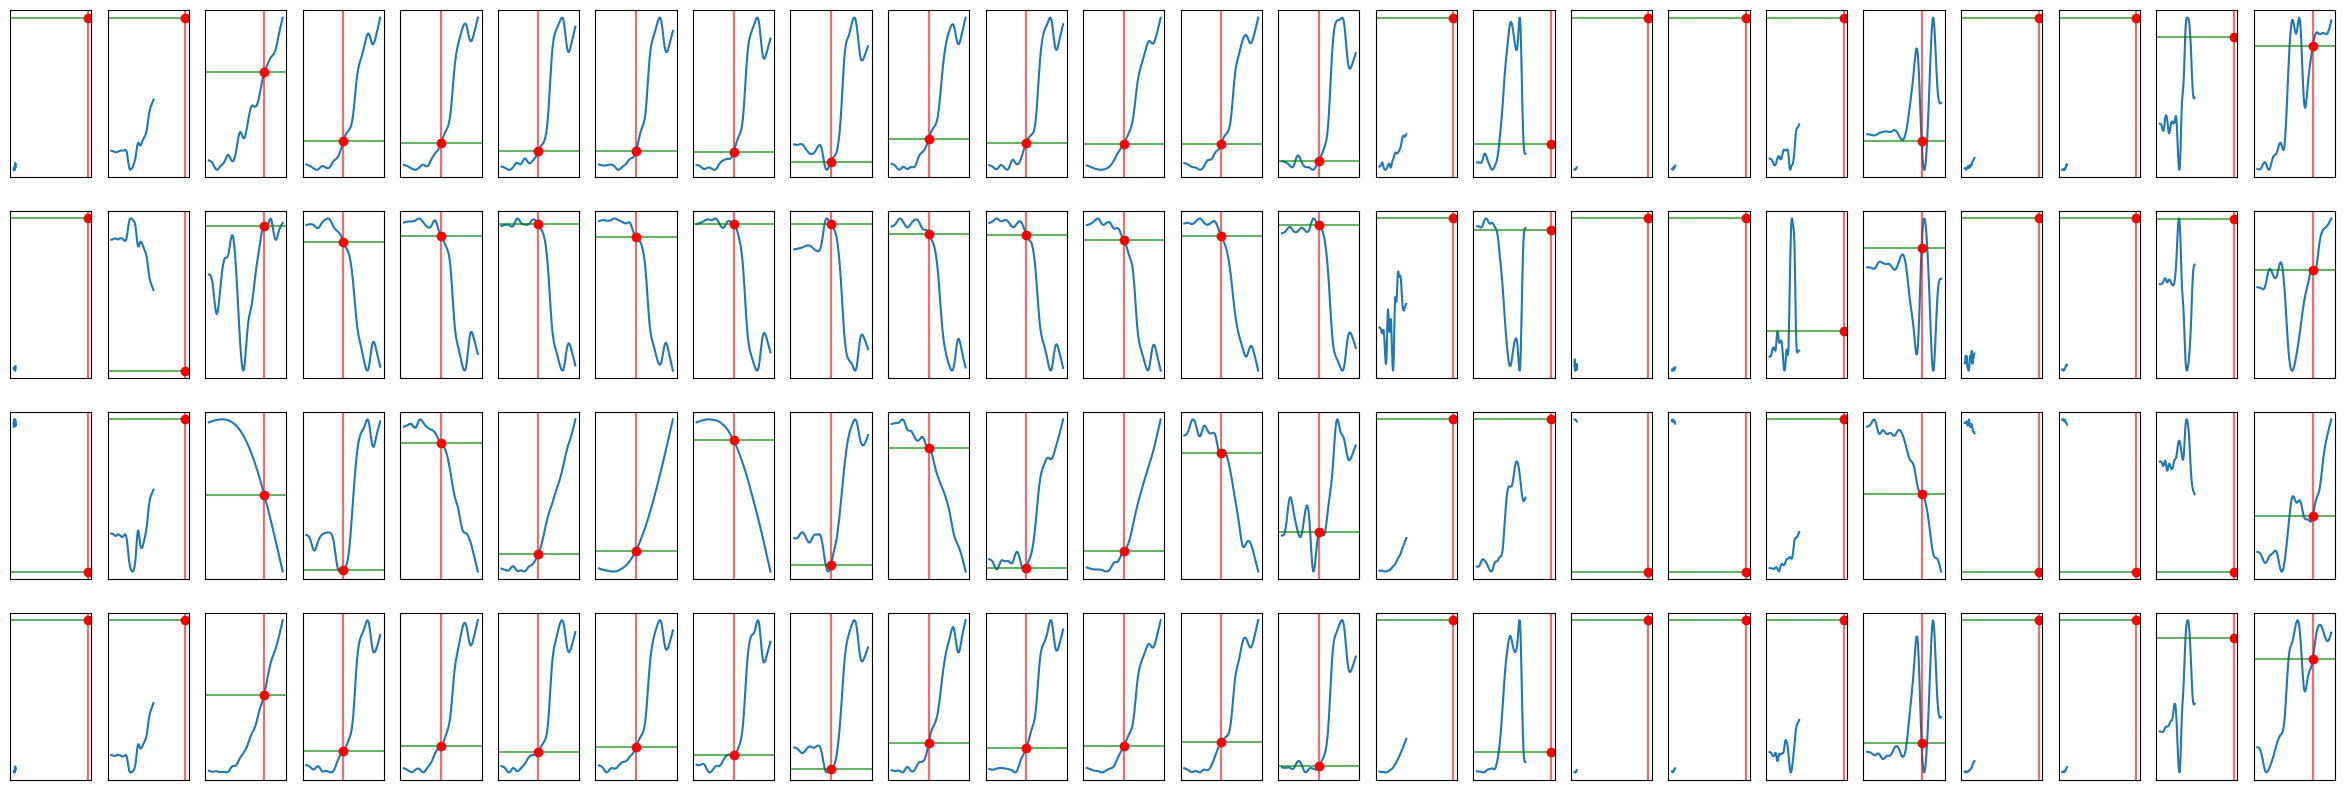

In [44]:
input_dim = x_train.shape[1]
layer1_dim = 4
layer2_dim = 1

# Architettura del modello
model = tf.keras.models.Sequential([
    DenseKAN(layer1_dim, grid_range=(-2,2), grid_size=20),
    DenseKAN(layer2_dim)
])

model.build(input_shape=(None, input_dim))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(x_train, y_train, epochs=10, batch_size=64)

input_l1 = int(model.layers[0].input_dim)
input_l2 = int(model.layers[0].units)
output_l2 = int(model.layers[1].units)
layer1_matrix = np.zeros((input_l2, input_l1))
layer2_input = np.zeros((input_l2, output_l2))

fig, axes = plt.subplots(input_l2, input_l1, figsize=(30, 10))

spline_list = model.layers[0].get_spline_list()
spline_list_1 = model.layers[1].get_spline_list()

print(layer2_input)
layer2_output = 0

for i in range(input_l1):
    for j in range(input_l2):
        xx = np.linspace(-2, 2, 100)
        yy = spline_list[i][j](tf.convert_to_tensor(xx, dtype=tf.float32))
        axes[j][i].plot(xx, yy)
        axes[j][i].set_xticks([])
        axes[j][i].set_yticks([])
        axes[j][i].axvline(x=my_record[i%input_dim], color='red', alpha=0.6)
        axes[j][i].axhline(y=spline_list[i][j](my_record[i%input_dim]), color='green', alpha=0.6)
        axes[j][i].plot(my_record[i%input_dim], spline_list[i][j](my_record[i%input_dim]), 'ro')
        layer1_matrix[j][i] = spline_list[i][j](my_record[i%input_dim])

for i in range(len(layer2_input)):
    layer2_input[i] = sum(layer1_matrix[i])

plt.show()

$$
KAN(x) = \sum_{i_{1}=1}^{5}{\phi_{1}(\sum_{i_{0}=1}^{26}{\phi_{0}(x_{i_0})})}
$$

IndexError: list index out of range

In [ ]:
final_result = sum(layer2_matrix[0])
print(f"Output della rete: {final_result}")

Output della rete: 46.47953054316724
